In [ ]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import ImageFolder

import argparse
import os
import random
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable
import pdb
import io
from torch.utils.data import Dataset, DataLoader
import h5py
from PIL import Image
import yaml
ngpu = 4
device = torch.device("cpu" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
%matplotlib inline

In [ ]:
def make_gen_block(input_channels, output_channels, kernel_size=2, stride=1, pad = 0, final_layer=False):
    if not final_layer:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, pad, bias = False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )
    else: # Final Layer
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, pad, bias = False),
            nn.Tanh()
        )
class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.img_size = 64
      self.nc = 3
      self.noise_dim = 100
      self.ngf = 64
      self.embed_dim = 1024
      self.projected_embed_dim = 128
      self.latent_dim = self.noise_dim + self.projected_embed_dim
      self.generator = nn.Sequential(
        make_gen_block(self.latent_dim, self.ngf*8, 4, 1, 0),
        make_gen_block(self.ngf*8, self.ngf*4, 4, 2, 1),
        make_gen_block(self.ngf*4, self.ngf*2, 4, 2, 1),
        make_gen_block(self.ngf*2, self.ngf, 4, 2, 1),
        make_gen_block(self.ngf, self.nc, 4, 2, 1, True),
        )
      
      self.projection = nn.Sequential(
			  nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
			  nn.BatchNorm1d(num_features=self.projected_embed_dim),
			  nn.LeakyReLU(negative_slope=0.2, inplace=True)
			  )
      
    def forward(self, embed_vector, z):
      projected_embed = self.projection(embed_vector).unsqueeze(2).unsqueeze(3)
      latent_vector = torch.cat([projected_embed, z], 1)
      output = self.generator(latent_vector)
      return output

In [ ]:

def build_gm():
  gmodel = Generator()
  print(gmodel)
  return gmodel
build_gm();

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(228, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpl

In [ ]:
class Concat_embed(nn.Module):

    def __init__(self, embed_dim, projected_embed_dim):
        super(Concat_embed, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=projected_embed_dim),
            nn.BatchNorm1d(num_features=projected_embed_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )

    def forward(self, inp, embed):
        projected_embed = self.projection(embed)
        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([inp, replicated_embed], 1)
        return hidden_concat

def make_disc_block(input_channels, output_channels, kernel_size=4, stride=2, pad = 1, first_layer=False):
        if not first_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, pad),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, pad),
                nn.LeakyReLU(0.2, inplace=True)
            )

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.img_size = 64
    self.nc = 3
    self.noise_dim = 100
    self.ndf = 64
    self.embed_dim = 1024
    self.projected_embed_dim = 128
    self.b_dim = 128
    self.c_dim = 64

    self.discriminator1 = nn.Sequential(
        make_disc_block(self.nc, self.ndf, 4, 2, 1, True),
        make_disc_block(self.ndf, self.ndf*2, 4, 2, 1),
        make_disc_block(self.ndf*2, self.ndf*4, 4, 2, 1),
        make_disc_block(self.ndf*4, self.ndf*8, 4, 2, 1),
        )
    self.projector = Concat_embed(self.embed_dim, self.projected_embed_dim)
    self.discriminator2 = nn.Sequential(
        nn.Conv2d(self.ndf*8 + self.projected_embed_dim, 1, 4, 1, 0, bias = False),
        nn.Sigmoid()
    )

  def forward(self, input, embed):
    x_1 = self.discriminator1(input)
    x = self.projector(x_1, embed)
    output = self.discriminator2(x)
    return output.view(-1, 1).squeeze(1), x_1

In [ ]:
def build_dm():
  dmodel = Discriminator()
  print(dmodel)
  return dmodel
build_dm();

Discriminator(
  (discriminator1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (projector): Concat_embed(
    

In [ ]:
class Text2ImageDataset(Dataset):

    def __init__(self, datasetFile, transform=None, split=0):
        self.datasetFile = datasetFile
        self.transform = transform
        self.dataset = None
        self.dataset_keys = None
        self.split = 'train' if split == 0 else 'valid' if split == 1 else 'test'
        self.h5py2int = lambda x: int(np.array(x))

    def __len__(self):
        f = h5py.File(self.datasetFile, 'r')
        self.dataset_keys = [str(k) for k in f[self.split].keys()]
        length = len(f[self.split])
        f.close()

        return length

    def __getitem__(self, idx):
        if self.dataset is None:
            self.dataset = h5py.File(self.datasetFile, mode='r')
            self.dataset_keys = [str(k) for k in self.dataset[self.split].keys()]

        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]

        right_image = bytes(np.array(example['img']))
        right_embed = np.array(example['embeddings'], dtype=float)
        wrong_image = bytes(np.array(self.find_wrong_image(example['class'])))
        inter_embed = np.array(self.find_inter_embed())

        right_image = Image.open(io.BytesIO(right_image)).resize((64, 64))
        wrong_image = Image.open(io.BytesIO(wrong_image)).resize((64, 64))

        right_image = self.validate_image(right_image)
        wrong_image = self.validate_image(wrong_image)

        txt = np.array(example['txt']).astype(str)

        sample = {
                'right_images': torch.FloatTensor(right_image),
                'right_embed': torch.FloatTensor(right_embed),
                'wrong_images': torch.FloatTensor(wrong_image),
                'inter_embed': torch.FloatTensor(inter_embed),
                'txt': str(txt)
                 }

        sample['right_images'] = sample['right_images'].sub_(127.5).div_(127.5)
        sample['wrong_images'] =sample['wrong_images'].sub_(127.5).div_(127.5)

        return sample

    def find_wrong_image(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        _category = example['class']

        if _category != category:
            return example['img']

        return self.find_wrong_image(category)

    def find_inter_embed(self):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        return example['embeddings']


    def validate_image(self, img):
        img = np.array(img, dtype=float)
        if len(img.shape) < 3:
            rgb = np.empty((64, 64, 3), dtype=np.float32)
            rgb[:, :, 0] = img
            rgb[:, :, 1] = img
            rgb[:, :, 2] = img
            img = rgb

        return img.transpose(2, 0, 1)                

In [ ]:
class Utils(object):

    @staticmethod
    def smooth_label(tensor, offset):
        return tensor + offset

    @staticmethod
    def save_checkpoint(discriminator, generator, dir_path, subdir_path, epoch):
        path =  os.path.join(dir_path, subdir_path)
        if not os.path.exists(path):
            os.makedirs(path)

        torch.save(discriminator.state_dict(), '{0}/disc_{1}.pth'.format(path, epoch))
        torch.save(generator.state_dict(), '{0}/gen_{1}.pth'.format(path, epoch))

    @staticmethod
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

In [ ]:
traindata = Text2ImageDataset('/content/drive/MyDrive/flowers.hdf5', split=0)
traindata_loader = DataLoader(traindata, batch_size=64, shuffle=True,
                        num_workers=2)
valdata = Text2ImageDataset('/content/drive/MyDrive/flowers.hdf5', split=1)
valdata_loader = DataLoader(valdata, batch_size=64, shuffle=True,
                        num_workers=2)
testdata = Text2ImageDataset('/content/drive/MyDrive/flowers.hdf5', split=2)
testdata_loader = DataLoader(testdata, batch_size=64, shuffle=True,
                        num_workers=2)

In [ ]:
print(len(traindata))


29390


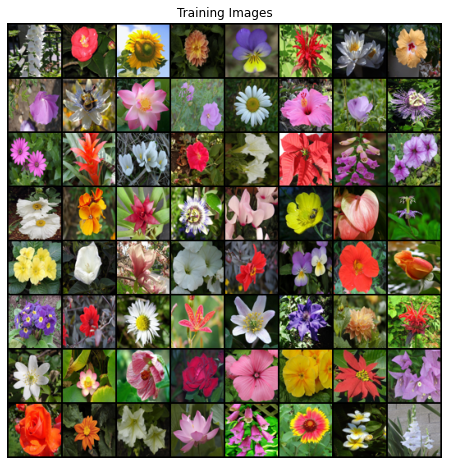

In [ ]:
real_batch = next(iter(traindata_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch['right_images'].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
class Helper(object):
  @staticmethod
  def fakePlotter(img_list):
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1].cpu().numpy(),(1,2,0)))
    plt.show()

  @staticmethod    
  def iteration_log(epoch, discriminator_loss, generator_loss, real_score, fake_score):
        print("Epoch: %d, discriminator_loss= %f, generator_loss= %f, D(X)= %f, D(G(X))= %f" % (epoch, discriminator_loss.data.cpu().mean(), generator_loss.data.cpu().mean(), real_score.data.cpu().mean(),fake_score.data.cpu().mean()))

In [ ]:
class generator_loss(torch.nn.Module):
    def __init__(self):
        super(generator_loss, self).__init__()
        self.estimator = nn.BCELoss()

    def forward(self, fake):
        batch_size = fake.size()[0]
        self.labels = Variable(torch.FloatTensor(batch_size).cpu().fill_(1))
        return self.estimator(fake, self.labels)

class discriminator_loss(torch.nn.Module):
    def __init__(self):
        super(discriminator_loss, self).__init__()
        self.estimator = nn.BCELoss()

    def forward(self, real, wrong, fake):
        batch_size = real.size()[0]
        self.real_labels = Variable(torch.FloatTensor(batch_size).cpu().fill_(1))
        self.fake_labels = Variable(torch.FloatTensor(batch_size).cpu().fill_(0))
        return self.estimator(real, self.real_labels) + 0.5 * (self.estimator(wrong, self.fake_labels) + self.estimator(fake, self.fake_labels))

In [ ]:
class DCGAN(object):
    def __init__(self, learning_rate, batch_size=64, epochs=1, pre_trained_gen=None, pre_trained_disc=None):

        self.generator = torch.nn.DataParallel(Generator().cpu())
        self.generator.apply(Utils.weights_init)
        self.discriminator = torch.nn.DataParallel(Discriminator().cpu())
        self.discriminator.apply(Utils.weights_init)

        self.noise_dim = 100
        self.l1_coef = 50
        self.l2_coef = 100
        self.beta1 = 0.5

        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = epochs
        self.traindata_loader = traindata_loader
        self.valdata_loader = valdata_loader
        self.testdata_loader = testdata_loader

        self.optimize_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=self.learning_rate, betas=(self.beta1, 0.999))
        self.optimize_generator = torch.optim.Adam(self.generator.parameters(), lr=self.learning_rate, betas=(self.beta1, 0.999))

        self.checkpoints_path = 'Trainingnew/checkpoints'
        self.train_save_path = 'Trainingnew/res'
        self.val_save_path = 'Validationnew/valres'
        self.test_save_path = 'Testingnew/testres'

    def train_dcgan(self):
        criterion = nn.BCELoss()
        l2_loss = nn.MSELoss()
        l1_loss = nn.L1Loss()
        print("Running..................")
        for epoch in range(self.num_epochs):
            img_list = []
            iteration = 0
            for sample in self.traindata_loader:
                Iterations.append(iteration)
                EpochsLib.append(epoch)
                iteration = iteration + 1
                right_images = sample['right_images']
                right_embed = sample['right_embed']
                wrong_images = sample['wrong_images']

                right_images = Variable(right_images.float()).cpu()
                right_embed = Variable(right_embed.float()).cpu()
                wrong_images = Variable(wrong_images.float()).cpu()

                real_labels = torch.ones(right_images.size(0))
                fake_labels = torch.zeros(right_images.size(0))

                smoothed_real_labels = torch.FloatTensor(Utils.smooth_label(real_labels.numpy(), -0.1))

                real_labels = Variable(real_labels).cpu()
                smoothed_real_labels = Variable(smoothed_real_labels).cpu()
                fake_labels = Variable(fake_labels).cpu()

                # Train the discriminator model
                self.discriminator.zero_grad()
                outputs, activation_real = self.discriminator(right_images, right_embed)
                real_loss = criterion(outputs, smoothed_real_labels)
                real_score = outputs

                noise = Variable(torch.randn(right_images.size(0), 100)).cpu()
                noise = noise.view(noise.size(0), 100, 1, 1)
                fake_images = self.generator(right_embed, noise)
                outputs, _ = self.discriminator(fake_images, right_embed)     
                fake_loss = criterion(outputs, fake_labels)
                fake_score = outputs

                discriminator_loss = real_loss + fake_loss

                discriminator_loss.backward()
                self.optimize_discriminator.step()

                # Train the generator model
                self.generator.zero_grad()
                noise = Variable(torch.randn(right_images.size(0), 100)).cpu()
                noise = noise.view(noise.size(0), 100, 1, 1)
                fake_images = self.generator(right_embed, noise)
                outputs, activation_fake = self.discriminator(fake_images, right_embed)
                _, activation_real = self.discriminator(right_images, right_embed)

                activation_fake = torch.mean(activation_fake, 0)
                activation_real = torch.mean(activation_real, 0)

                generator_loss = criterion(outputs, real_labels) + self.l2_coef * l2_loss(activation_fake, activation_real.detach()) + self.l1_coef * l1_loss(fake_images, right_images)

                generator_loss.backward()
                self.optimize_generator.step()
                if (iteration%100)==0:
                    Helper.iteration_log(epoch,discriminator_loss, generator_loss, real_score, fake_score)
                img_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))
                Generator_losses.append(generator_loss.data.cpu().mean().item())
                Discriminator_losses.append(discriminator_loss.data.cpu().mean().item())
                Real_scores.append(real_score.data.cpu().mean().item())
                Fake_scores.append(fake_score.data.cpu().mean().item())
            #Helper.fakePlotter(img_list)
            #print("Done: ", epoch)
            Utils.save_checkpoint(self.discriminator, self.generator, self.checkpoints_path, '', epoch)
        print("Done..................")

    def train_predict(self):
        for sample in self.traindata_loader:
            right_images = sample['right_images']
            right_embed = sample['right_embed']
            txt = sample['txt']

            if not os.path.exists('resultsnew/{0}'.format(self.train_save_path)):
                os.makedirs('resultsnew/{0}'.format(self.train_save_path))

            right_images = Variable(right_images.float()).cpu()
            right_embed = Variable(right_embed.float()).cpu()

            noise = Variable(torch.randn(right_images.size(0), 100)).cpu()
            noise = noise.view(noise.size(0), 100, 1, 1)
            fake_images = self.generator(right_embed, noise)

            for image, t in zip(fake_images, txt):
                im = Image.fromarray(image.data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).cpu().numpy())
                try:
                  im.save('resultsnew/{0}/{1}.jpg'.format(self.train_save_path, t.replace("/", "").replace(".\n", "").replace(" ", "")[:100]))
                except:
                  print('')
                print(t)
            break
    
    def val_predict(self):
        for sample in self.valdata_loader:
            right_images = sample['right_images']
            right_embed = sample['right_embed']
            txt = sample['txt']

            if not os.path.exists('resultsnew/{0}'.format(self.val_save_path)):
                os.makedirs('resultsnew/{0}'.format(self.val_save_path))

            right_images = Variable(right_images.float()).cpu()
            right_embed = Variable(right_embed.float()).cpu()

            noise = Variable(torch.randn(right_images.size(0), 100)).cpu()
            noise = noise.view(noise.size(0), 100, 1, 1)
            fake_images = self.generator(right_embed, noise)

            for image, t in zip(fake_images, txt):
                im = Image.fromarray(image.data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).cpu().numpy())
                try:
                  im.save('resultsnew/{0}/{1}.jpg'.format(self.val_save_path, t.replace("/", "").replace(".\n", "").replace(" ", "")[:100]))
                except:
                  print('')
                print(t)
            break

    def test_predict(self):
        for sample in self.testdata_loader:
            right_images = sample['right_images']
            right_embed = sample['right_embed']
            txt = sample['txt']

            if not os.path.exists('resultsnew/{0}'.format(self.test_save_path)):
                os.makedirs('resultsnew/{0}'.format(self.test_save_path))

            right_images = Variable(right_images.float()).cpu()
            right_embed = Variable(right_embed.float()).cpu()

            noise = Variable(torch.randn(right_images.size(0), 100)).cpu()
            noise = noise.view(noise.size(0), 100, 1, 1)
            fake_images = self.generator(right_embed, noise)

            for image, t in zip(fake_images, txt):
                im = Image.fromarray(image.data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).cpu().numpy())
                try:
                  im.save('resultsnew/{0}/{1}.jpg'.format(self.test_save_path, t.replace("/", "").replace(".\n", "").replace(" ", "")[:100]))
                except:
                  print('')
                print(t)
            break                                                             

In [ ]:
Generator_losses = []
Discriminator_losses = []
Real_scores = []
Fake_scores = []
Iterations = []
EpochsLib = []
dcganmodel = DCGAN(0.0002, 64, 5, None, None)
dcganmodel.train_dcgan()

Running..................
Epoch: 0, discriminator_loss= 0.947882, generator_loss= 31.718767, D(X)= 0.869102, D(G(X))= 0.386330
Epoch: 0, discriminator_loss= 0.855936, generator_loss= 28.356979, D(X)= 0.841302, D(G(X))= 0.259400
Epoch: 0, discriminator_loss= 0.717069, generator_loss= 28.224367, D(X)= 0.617948, D(G(X))= 0.089038
Epoch: 0, discriminator_loss= 0.868744, generator_loss= 26.811710, D(X)= 0.572173, D(G(X))= 0.171793
Epoch: 1, discriminator_loss= 1.250378, generator_loss= 26.902401, D(X)= 0.344971, D(G(X))= 0.078915
Epoch: 1, discriminator_loss= 0.901866, generator_loss= 27.353687, D(X)= 0.718751, D(G(X))= 0.327715
Epoch: 1, discriminator_loss= 1.208830, generator_loss= 24.306236, D(X)= 0.403853, D(G(X))= 0.202425
Epoch: 1, discriminator_loss= 0.889955, generator_loss= 27.810366, D(X)= 0.724363, D(G(X))= 0.321727
Epoch: 2, discriminator_loss= 0.841192, generator_loss= 27.119896, D(X)= 0.778164, D(G(X))= 0.334347
Epoch: 2, discriminator_loss= 0.744178, generator_loss= 25.627195

In [ ]:

dcganmodel.train_predict()

the flower on this particular picture has petals as well as a sepal. the petals are white.

the petals of the flower are wide and curved, and a vibrant orange color.

the petals of this flower are purple and yellow with a short stigma

this flower has a smooth edge with orange pedals and a yellow center.

the flower shown has several white petals with yellow in the center.

this flower has pink and white petals with some being sure white petals and yellow stamen

this flower has wide rounded pale petals around a layer of fringe in purple and white.

the flower has petals that are violet which is fading gradually towards their edges and the stamen are arranged like a disc in the centre

this flower is pink and white in color, with petals that are spotted on the inside.

this flower has a bright pink colored petals and a pink anther in the middle

this flower has thick star shaped maroon petals as its main feature.

this flower has five rounded and very large petals in a dark red shade.


In [ ]:
dcganmodel.val_predict()

this flower has thin pink petals as its main feature.

this purple flower has rounded leaves and white stamen with white anthers.

this flower has white petals with purple stamen in the center of it.

a large flower with a dull pink pedals and green tips.

two purple trumpet like flowers each with five petals and a white tipped stigma.

this flower has a wheel-like configuration of light pink petals with slightly notched ends.

this flower has pink petals that curl away from the pistil with off white stamen.

the petals on this flower are white in color with jagged looking edges as they lay flat out from the stem.

this flower is green and red in color, with petals that are curled upward.

this unique flower almost looks prickly in appearance and features frost-like petals.

this flower is purple in color, and has petals that are lighter near the bottom.

this flower has purple petals as well as a green pedicel.

a red colored flower with a bending brown pedicel and green sepal.

this 

In [ ]:
dcganmodel.test_predict()

this flower has petals that are yellow with purple lines

this flower has petals that are red with black dots

the petals of the flower are short and pointed, that consist of a bright pink color.

a tiny purple flower with a green receptacle and purple style.

the flower has a very smooth white petal with a green pedicel

this flower has petals that are purple with dark lines

this flower has large pink petals and a lot of dark spots and long red stamen

this flower is pink and yellow in color, with petals that are bell shaped.

this particular flower has petals that are purple and green

this flower has overlapping layers of bright red petals with dark brown accents.

this flower has a large textured yellow pollen tube surrounded by a pointed white petal.

this flower has a wide yellow center surrounded by hundreds of thin fringed yellow petals.

this flower is pink and orange in color, with oval shaped petals.

this flower has a unique shape and the color is lavender

this flower has

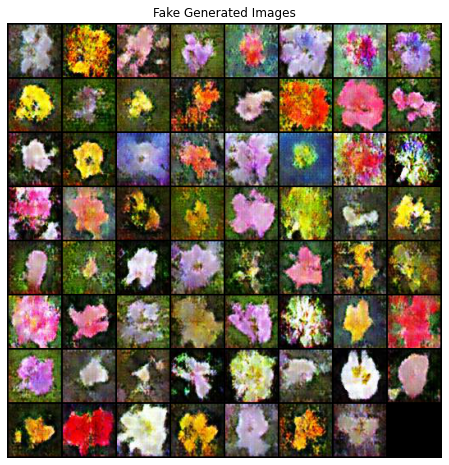

In [ ]:
dataroot = "resultsnew/Testingnew/"
plotdataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(plotdataset, batch_size=64,
                                         shuffle=True, num_workers=2)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Generated Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

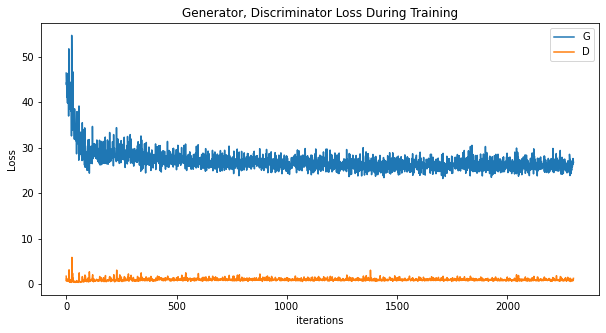

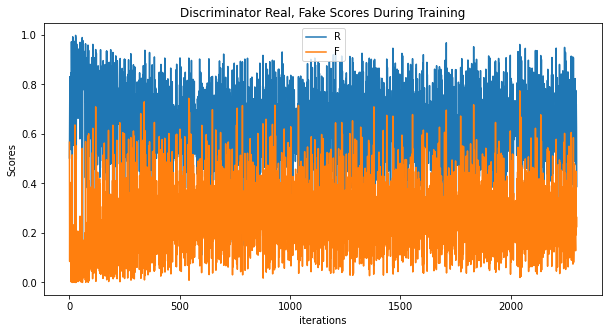

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator, Discriminator Loss During Training")
plt.plot(Generator_losses,label="G")
plt.plot(Discriminator_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Discriminator Real, Fake Scores During Training")
plt.plot(Real_scores,label="R")
plt.plot(Fake_scores,label="F")
plt.xlabel("iterations")
plt.ylabel("Scores")
plt.legend()
plt.show()

In [ ]:
import pickle
import pandas as pd

outfile = 'epoch_loss_new.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Epoch" : [], "Iteration": [], "GeneratorLoss": [], "DiscriminatorLoss": [], "RealScore": [], "FakeScore": []}

for i in range(0, len(Iterations)):
    dataframe_dict['Epoch'].append(EpochsLib[i])
    dataframe_dict['Iteration'].append(Iterations[i])
    dataframe_dict['GeneratorLoss'].append(Generator_losses[i])
    dataframe_dict['DiscriminatorLoss'].append(Discriminator_losses[i])
    dataframe_dict['RealScore'].append(Real_scores[i])
    dataframe_dict['FakeScore'].append(Fake_scores[i])

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

Written to csv file epoch_loss_new.csv


end